In [1]:
# Initializing Model and First Analysis Run
import os
nLoadCases = 900
os.environ["MAX_LOADCASE"] = str(nLoadCases)

from scipy import sparse as sp
import numpy as np
from Examples.RDSO45mTruss.Structure3D import Structure3D
from Models import DOFClass
import matplotlib.pyplot as plt

# Defining the structure
structure = Structure3D()

# Loading ImbalancedActionVector from File
ImbalancedActionVectorFromFile = sp.lil_array(sp.load_npz(f'DataExchange/.ImbalancedActionVector{nLoadCases}.npz'))
DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()

# Analysing file
staticDisplacementVector = DOFClass.analyse()
maxMidSpanStaticDisplacement = np.min(staticDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:])
print(f"Maximum displacement @ midspan for static speed case is {maxMidSpanStaticDisplacement}")

c:\miniconda3\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Maximum displacement @ midspan for static speed case is -0.010320603868077732


Text(0, 0.5, 'Force (tons)')

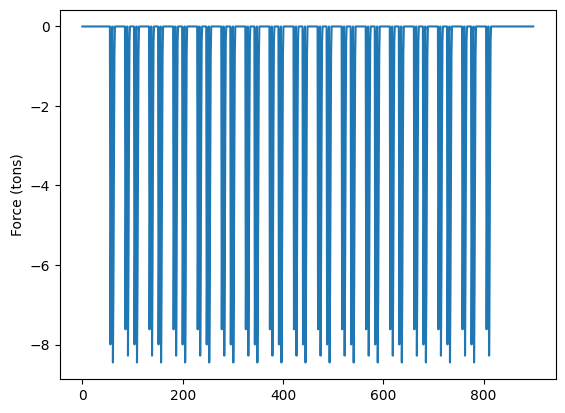

In [2]:
plt.plot(ImbalancedActionVectorFromFile[[structure.stringers[3].nodes[0].DOF[2].id],:].todense().flatten()/9806)
plt.ylabel("Force (tons)")

In [3]:
# Eigen Value Analysis of the model
import numpy as np
import matplotlib.pyplot as plt

nModes = 1050
eigenValues, eigenVectors, effectiveMass, massParticipationFactor = DOFClass.eig(nModes)
dampingRatios = np.ones((nModes,), np.float64) * 0.02
T = 2*np.pi/eigenValues**0.5
print(f"Eigenvalue Analysis Results with Full Fixity")
print("No.\tTime\tFreq.:\tDX\tDY\tDZ\tRX\tRY\tRz")
for i, (_T,_MP) in enumerate(zip(T, massParticipationFactor*100)):
  print(f"{i+1}\t{_T:.3f}\t{1/_T:.2f}:\t"+''.join([f"{_:.2f}\t" for _ in _MP]))


Eigenvalue Analysis Results with Full Fixity
No.	Time	Freq.:	DX	DY	DZ	RX	RY	Rz
1	0.269	3.72:	0.00	78.06	0.00	1.15	0.00	0.00	
2	0.185	5.40:	3.78	0.00	67.76	0.00	0.10	0.00	
3	0.160	6.23:	0.02	0.00	0.00	0.00	0.00	0.00	
4	0.160	6.25:	0.00	0.00	0.36	0.00	0.00	0.00	
5	0.160	6.25:	0.00	0.00	0.00	0.00	0.00	0.00	
6	0.160	6.25:	0.00	0.00	0.06	0.00	0.00	0.00	
7	0.160	6.25:	0.00	0.00	0.00	0.00	0.00	0.00	
8	0.160	6.25:	0.00	0.00	0.05	0.00	0.00	0.00	
9	0.160	6.25:	0.00	0.00	0.00	0.00	0.00	0.00	
10	0.153	6.54:	1.80	0.00	10.19	0.00	0.05	0.00	
11	0.152	6.57:	0.00	7.37	0.01	2.85	0.00	0.00	
12	0.122	8.22:	0.12	0.00	0.00	0.00	0.00	0.00	
13	0.121	8.25:	0.01	0.00	0.12	0.00	0.00	0.00	
14	0.121	8.26:	0.00	0.00	0.00	0.00	0.00	0.00	
15	0.121	8.27:	0.00	0.00	0.02	0.00	0.00	0.00	
16	0.121	8.27:	0.00	0.00	0.00	0.00	0.00	0.00	
17	0.118	8.46:	0.99	0.06	0.74	0.01	0.03	0.04	
18	0.118	8.46:	0.36	0.15	0.31	0.01	0.01	0.10	
19	0.089	11.24:	76.67	0.00	3.12	0.00	2.73	0.00	
20	0.077	12.93:	0.00	0.09	0.00	0.00	0.00	0.05	
21	0

Maximum displacement @ midspan for 0.0001kmph speed case is -0.01032060447879085
Maximum displacement @ midspan for 50kmph speed case is -0.011117999619721462
Maximum displacement @ midspan for 75kmph speed case is -0.012733425888741299
Maximum displacement @ midspan for 77.5kmph speed case is -0.013794791495798967
Maximum displacement @ midspan for 100kmph speed case is -0.011240281684232419
Maximum displacement @ midspan for 150kmph speed case is -0.015201957420825592
Maximum displacement @ midspan for 155kmph speed case is -0.01730985323503423
Maximum displacement @ midspan for 160kmph speed case is -0.015248780053571113
Maximum displacement @ midspan for 165kmph speed case is -0.013272085361072796
Maximum displacement @ midspan for 170kmph speed case is -0.012084563381079787
Maximum displacement @ midspan for 175kmph speed case is -0.011780061875659982


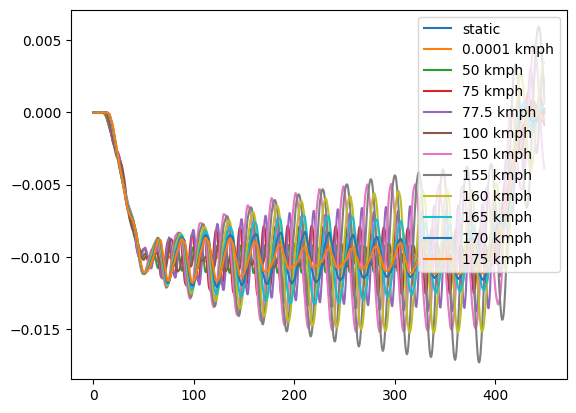

In [9]:
# Plotting the dispalcement at bottom of the steel truss 
DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()

def performTimeHistoryAnalysis(speed_kmph):
  speed_mps = speed_kmph/3.6
  dt = 150/speed_mps/nLoadCases
  timeHistoryDisplacementVector, timeHistoryVelocityVector, timeHistoryAccelerationVector = DOFClass.analyseTimeHistoryNewmark(dt, eigenValues, eigenVectors, dampingRatios)
  midSpanMaxDisplacement = np.min(timeHistoryDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:])
  print(f"Maximum displacement @ midspan for {speed_kmph}kmph speed case is {midSpanMaxDisplacement}")
  plt.plot(x, timeHistoryDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:], label=f"{speed_kmph} kmph")

x = np.arange(nLoadCases)/nLoadCases*(450*nLoadCases/(nLoadCases+1))
plt.plot(x, staticDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:], label=f"static")
performTimeHistoryAnalysis(0.0001)
# performTimeHistoryAnalysis(5)
# performTimeHistoryAnalysis(20)
performTimeHistoryAnalysis(50)
performTimeHistoryAnalysis(75)
performTimeHistoryAnalysis(77.5)
performTimeHistoryAnalysis(100)
performTimeHistoryAnalysis(150)
performTimeHistoryAnalysis(155)
performTimeHistoryAnalysis(160)
performTimeHistoryAnalysis(165)
performTimeHistoryAnalysis(170)
performTimeHistoryAnalysis(175)
# performTimeHistoryAnalysis(200)
# performTimeHistoryAnalysis(400)
# performTimeHistoryAnalysis(1000)
# performTimeHistoryAnalysis(2000)
plt.legend()
plt.show()

[10.0, 20.0, 37.5, 52.5, 77.5, 100.0, 115.0, 155.0, 190.0]


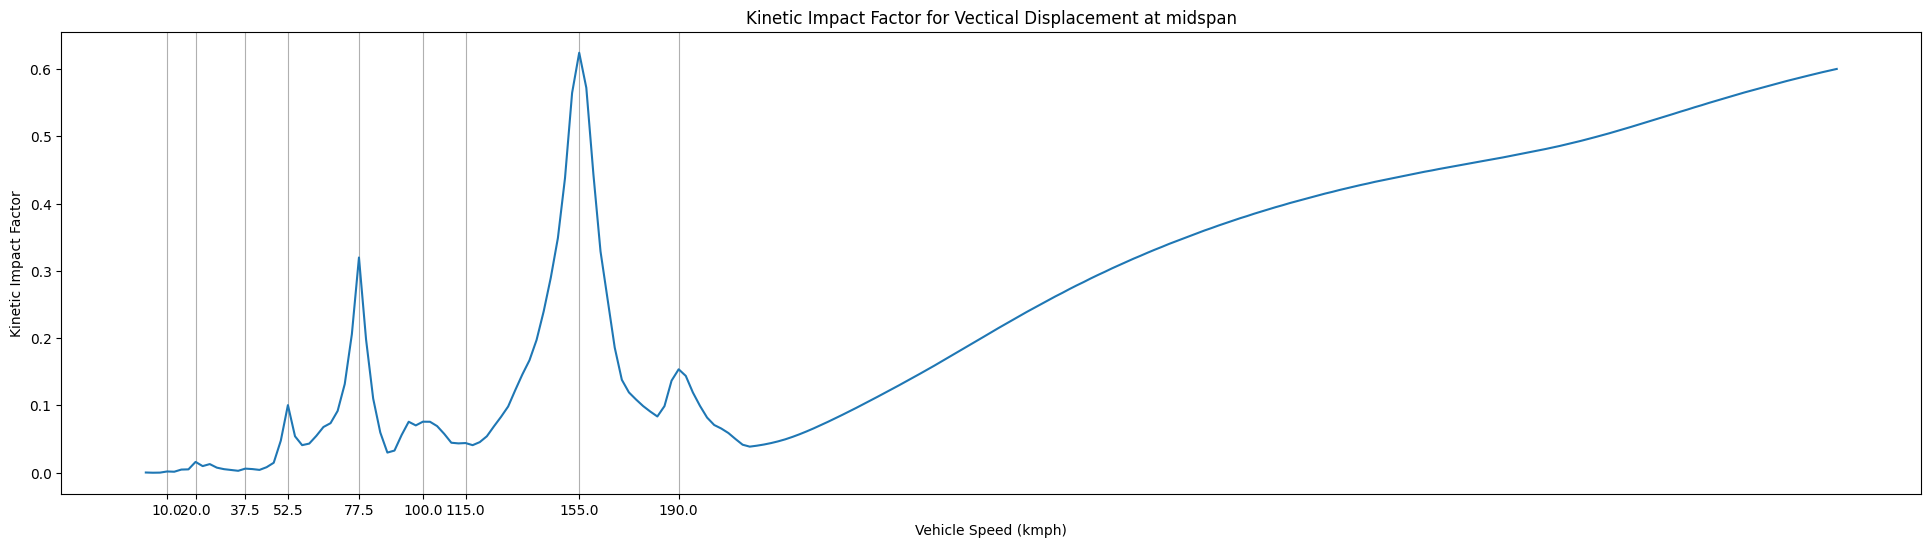

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

nModes = 50
eigenValues, eigenVectors, effectiveMass, massParticipationFactor = DOFClass.eig(nModes)
dampingRatios = np.ones((nModes,), np.float64) * 0.02

DOFClass.ImbalancedActionVector = ImbalancedActionVectorFromFile.copy()

def getMaxMidSpanDisplacementTimeHistoryAnalysis(speed_kmph):
  speed_mps = speed_kmph/3.6
  dt = 150/speed_mps/nLoadCases
  timeHistoryDisplacementVector, timeHistoryVelocityVector, timeHistoryAccelerationVector = DOFClass.analyseTimeHistory(dt, eigenValues, eigenVectors, dampingRatios)
  midSpanMaxDisplacement = np.min(timeHistoryDisplacementVector[structure.truss1.node_by_name("L4").DOF[2].id,:])
  # print(f"Maximum displacement @ midspan for {speed_kmph}kmph speed case is {midSpanMaxDisplacement}")
  return midSpanMaxDisplacement

maxMidSpanStaticDisplacement = getMaxMidSpanDisplacementTimeHistoryAnalysis(0.01)
speeds = np.arange(2.5, 600, 2.5)
maxMidspanDisplacement = []
maxFactor = 0
for speed in speeds:
  # maxFactor = max(getMaxMidSpanDisplacementTimeHistoryAnalysis(speed)/maxMidSpanStaticDisplacement - 1, maxFactor)
  maxFactor = getMaxMidSpanDisplacementTimeHistoryAnalysis(speed)/maxMidSpanStaticDisplacement - 1
  maxMidspanDisplacement.append(maxFactor)

peak_speeds = [speeds[_] for _ in signal.find_peaks(maxMidspanDisplacement, distance=3)[0]]
print(peak_speeds)
plt.figure(figsize=(24,6))
plt.plot(speeds, maxMidspanDisplacement)
plt.title("Kinetic Impact Factor for Vectical Displacement at midspan")
plt.ylabel("Kinetic Impact Factor")
plt.xlabel("Vehicle Speed (kmph)")
plt.xticks(peak_speeds)
plt.grid(axis='x')
plt.show()